<a href="https://colab.research.google.com/github/jhwnoh/UST2024Fall_MaterialsInformatics/blob/main/Week13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# --------------------------------------------------
# 1. Load MNIST + Create Train/Validation Split
# --------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train = datasets.MNIST(root=".", train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root=".", train=False, download=True, transform=transform)

# 90% train / 10% validation split
train_size = int(0.9 * len(full_train))
val_size   = len(full_train) - train_size

train_set, val_set = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=1000, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=1000, shuffle=False)


# --------------------------------------------------
# 2. Example Model (CNN)
# --------------------------------------------------
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 28 → 14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)        # 14 → 7
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


# --------------------------------------------------
# 3. Helper: Evaluate Accuracy and Loss
# --------------------------------------------------
def evaluate(model, loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    avg_acc  = correct / total
    return avg_loss, avg_acc


# --------------------------------------------------
# 4. Train + Validate + Test
# --------------------------------------------------
def train_model(model, train_loader, val_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ---- Validation evaluation ----
        val_loss, val_acc = evaluate(model, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

    # ---- Final test evaluation ----
    test_loss, test_acc = evaluate(model, test_loader, device)
    print("\n==========================")
    print(f"Final Test Loss: {test_loss:.4f}")
    print(f"Final Test Accuracy: {test_acc:.4f}")
    print("==========================")

    return model


# --------------------------------------------------
# 5. Run
# --------------------------------------------------
model = CNN()
train_model(model, train_loader, val_loader, test_loader)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


Using device: cuda


 20%|██        | 1/5 [00:16<01:04, 16.22s/it]

Epoch 1/5 | Validation Loss: 0.0773 | Validation Accuracy: 0.9757


 40%|████      | 2/5 [00:30<00:45, 15.13s/it]

Epoch 2/5 | Validation Loss: 0.0447 | Validation Accuracy: 0.9873


 60%|██████    | 3/5 [00:44<00:29, 14.74s/it]

Epoch 3/5 | Validation Loss: 0.0536 | Validation Accuracy: 0.9835


 80%|████████  | 4/5 [01:00<00:15, 15.18s/it]

Epoch 4/5 | Validation Loss: 0.0423 | Validation Accuracy: 0.9880


100%|██████████| 5/5 [01:15<00:00, 15.02s/it]

Epoch 5/5 | Validation Loss: 0.0479 | Validation Accuracy: 0.9880



Final Test Loss: 0.0414
Final Test Accuracy: 0.9871


CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
TorchModule = {'linear':nn.Linear,
               'conv1d':nn.Conv1d,
               'conv2d':nn.Conv2d,
               'conv3d':nn.Conv3d,
               'convtrans1d':nn.ConvTranspose1d,
               'convtrans2d':nn.ConvTranspose2d,
               'convtrans3d':nn.ConvTranspose3d,
               'maxpool1d':nn.MaxPool1d,
               'maxpool2d':nn.MaxPool2d,
               'maxpool3d':nn.MaxPool3d,
               'sigmoid':nn.Sigmoid(),
               'tanh':nn.Tanh(),
               'relu':nn.ReLU(),
               'lrelu':nn.LeakyReLU(),
               'bn1d':nn.BatchNorm1d,
               'bn2d':nn.BatchNorm2d,
               'bn3d':nn.BatchNorm3d,
               'dropout':nn.Dropout}

def LayerGroup(mylayers):
    mylayer_list = mylayers.split(';')

    module_list = []
    for mylayer in mylayer_list:
        if '-' in mylayer:
            tmp = mylayer.split('-')

            name = tmp[0]

            if name == 'linear':
                dims = [int(v) for v in tmp[1].split(',')]
                sub_model = TorchModule[name](*dims)
            elif 'conv' in name:
                dims = [int(v) for v in tmp[1].split(',')]
                sub_model = TorchModule[name](*dims)
            elif 'pool' in name:
                dims = [int(v) for v in tmp[1].split(',')]
                sub_model = TorchModule[name](*dims)
            elif 'bn' in name:
                dims = [int(v) for v in tmp[1].split(',')]
                sub_model = TorchModule[name](*dims)
            elif name == 'dropout':
                dims = [float(v) for v in tmp[1].split(',')]
                sub_model = TorchModule[name](*dims)

            module_list.append(sub_model)

        else:
            module_list.append(TorchModule[mylayer])

    module_list = nn.ModuleList(module_list)
    return nn.Sequential(*module_list)

# Examples with this module function.

In [ ]:
# Neural network; (B,100) - (B,50) - (B,10) - (B,1) (relu as activation function)
layer_text = 'linear-100,50;relu;linear-50,10;relu;linear-10,1'
model = LayerGroup(layer_text).cuda()
print(model)

x = torch.randn(10,100).cuda()
y = model(x)
print(y.shape)

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
torch.Size([10, 1])


In [ ]:
# Convolution operations; (B,3,32,32) - (B,32,16,16) - (B,64,8,8) - (B,128,4,4) (lrelu as activation function)
layer_text = 'conv2d-3,32,4,2,1;lrelu;conv2d-32,64,4,2,1;lrelu;conv2d-64,128,4,2,1'
model = LayerGroup(layer_text).cuda()
print(model)

x = torch.randn(10,3,32,32).cuda()
y = model(x)
print(y.shape)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
torch.Size([10, 128, 4, 4])


In [ ]:
# Convolution operations; (B,3,32,32) - BatchNorm - (B,32,16,16) - BatchNorm - (B,64,8,8) - BatchNorm - (B,128,4,4) (add lrelu after BatchNorm)
# You don't need to write all model information in single line
# Define each layer module and then combine it!

conv_text1 = 'conv2d-3,32,4,2,1;bn2d-32;lrelu'
conv_text2 = 'conv2d-32,64,4,2,1;bn2d-64;lrelu'
conv_text3 = 'conv2d-64,128,4,2,1;bn2d-128;lrelu'
model = LayerGroup(';'.join([conv_text1,conv_text2,conv_text3])).cuda()
print(model)

x = torch.randn(10,3,32,32).cuda()
y = model(x)
print(y.shape)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
)
torch.Size([10, 128, 4, 4])


In [ ]:
# Convolution operations; (B,3,32,32) - (B,32,16,16) - (B,64,8,8) - (B,128,4,4) - (B,256,1,1) (lrelu as activation function)
# You don't need to write all model information in single line
# Define each layer module and then combine it!

conv_text1 = 'conv2d-3,32,4,2,1;bn2d-32;lrelu'
conv_text2 = 'conv2d-32,64,4,2,1;bn2d-64;lrelu'
conv_text3 = 'conv2d-64,128,4,2,1;bn2d-128;lrelu'
conv_text4 = 'conv2d-128,256,4,4,0;lrelu'

model = LayerGroup(';'.join([conv_text1,conv_text2,conv_text3,conv_text4])).cuda()
print(model)

x = torch.randn(10,3,32,32).cuda()
y = model(x)
print(y.shape)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(4, 4))
  (10): LeakyReLU(negative_slope=0.01)
)
torch.Size([10, 256, 1, 1])


In [ ]:
# Combine multiple operations (Convolution -> Fully connected neural network)
# Convolution; (B,3,32,32) - BatchNorm - (B,32,16,16) - BatchNorm - (B,64,8,8) - BatchNorm - (B,128,4,4) (add lrelu after BatchNorm)
# FCNN; (B,128*4*4) - (B,512) - (B,128) - (B,5) (relu between linear layer)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()

        conv_text1 = 'conv2d-3,32,4,2,1;bn2d-32;lrelu'
        conv_text2 = 'conv2d-32,64,4,2,1;bn2d-64;lrelu'
        conv_text3 = 'conv2d-64,128,4,2,1;bn2d-128;lrelu'
        self.conv_block =  LayerGroup(';'.join([conv_text1,conv_text2,conv_text3]))

        fc_text = f'linear-{128*4*4},512;relu;linear-512,128;relu;linear-128,5'
        self.fcnn = LayerGroup(fc_text)

    def forward(self,x):
        x = self.conv_block(x)
        x = x.view(-1,128*4*4)
        x = self.fcnn(x)
        return x

my_model = MyModel().cuda()
print(my_model)

x = torch.randn(10,3,32,32).cuda()
y = my_model(x)
print(y.shape)

MyModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (fcnn): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=5, bias=True)
  )
)
torch.Size([10, 5])


# Example codes on AE, VAE, GAN

# Autoencoder

In [ ]:
# Example for autoencoder with linear layers

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()

        enc_info = 'linear-784,512;relu;linear-512,20'
        dec_info = 'linear-20,512;relu;linear-512,784;sigmoid'

        self.encoder = LayerGroup(enc_info)
        self.decoder = LayerGroup(dec_info)

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

AE = Autoencoder().cuda()
print(AE)

x = torch.randn(10,784).cuda()
z,x_pred = AE(x)
print(x.shape)
print(z.shape)
print(x_pred.shape)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
torch.Size([10, 784])
torch.Size([10, 20])
torch.Size([10, 784])


In [ ]:
# Example for autoencoder with linear layers

class Autoencoder(nn.Module):
    def __init__(self,enc_info,dec_info):
        super(Autoencoder,self).__init__()

        self.encoder = LayerGroup(enc_info)
        self.decoder = LayerGroup(dec_info)

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

enc_info = 'linear-784,512;relu;linear-512,20'
dec_info = 'linear-20,512;relu;linear-512,784;sigmoid'

AE = Autoencoder(enc_info,dec_info).cuda()
print(AE)

x = torch.randn(10,784).cuda()
z,x_pred = AE(x)
print(x.shape)
print(z.shape)
print(x_pred.shape)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
torch.Size([10, 784])
torch.Size([10, 20])
torch.Size([10, 784])


In [ ]:
# Example for autoencoder with linear layers

class Autoencoder(nn.Module):
    def __init__(self,dim_x,dim_h,dim_z):
        super(Autoencoder,self).__init__()

        self.enc_info = f'linear-{dim_x},{dim_h};relu;linear-{dim_h},{dim_z}'
        self.dec_info = f'linear-{dim_z},{dim_h};relu;linear-{dim_h},{dim_x};sigmoid'

        self.encoder = LayerGroup(self.enc_info)
        self.decoder = LayerGroup(self.dec_info)

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

dim_x = 28*28
dim_h = 512
dim_z = 64

AE = Autoencoder(dim_x,dim_h,dim_z).cuda()
print(AE)

x = torch.randn(10,784).cuda()
z,x_pred = AE(x)
print(x.shape)
print(z.shape)
print(x_pred.shape)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
torch.Size([10, 784])
torch.Size([10, 64])
torch.Size([10, 784])


============= Epoch: 1 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 352.33it/s]


[0.022402936772505443, 0.009141438747942448]
============= Epoch: 2 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 349.73it/s]


[0.007488472546140353, 0.006121017156541348]
============= Epoch: 3 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 338.00it/s]


[0.005463774878531695, 0.004834444560855627]
============= Epoch: 4 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 344.93it/s]


[0.0045026938166469336, 0.004216966351494193]
============= Epoch: 5 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 362.92it/s]


[0.003925427800665299, 0.003691023699194193]
============= Epoch: 6 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 367.51it/s]


[0.0035516273101170856, 0.0034798487856984137]
============= Epoch: 7 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 388.86it/s]


[0.0032779794450849293, 0.0033449169110506775]
============= Epoch: 8 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 376.70it/s]


[0.0030912135027348995, 0.003159541504085064]
============= Epoch: 9 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 363.54it/s]


[0.0029493141933033865, 0.003021645887196064]
============= Epoch: 10 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 319.14it/s]


[0.0028353020153939726, 0.0029551427222788335]


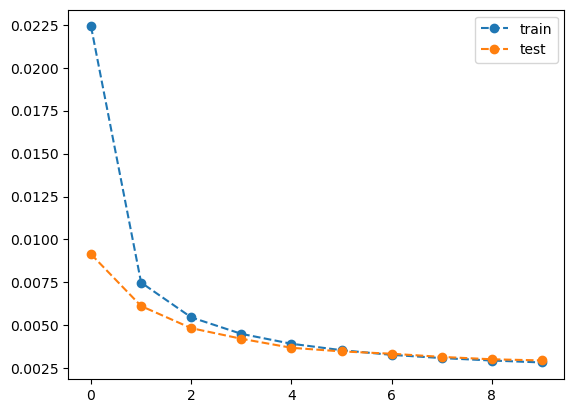

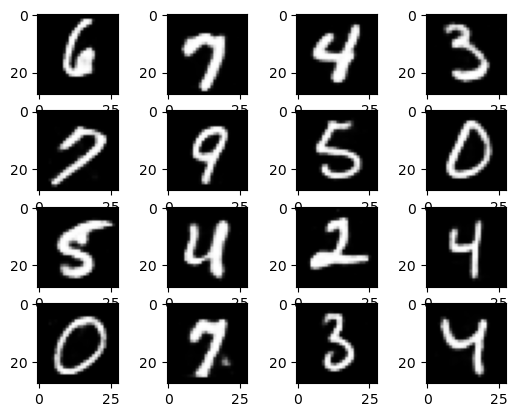

In [ ]:
# Write code for autoencoder training with MNIST dataset

# Model construction
class Autoencoder(nn.Module):
    def __init__(self,dim_x,dim_h,dim_z):
        super(Autoencoder,self).__init__()

        self.enc_info = f'linear-{dim_x},{dim_h};relu;linear-{dim_h},{dim_z}'
        self.dec_info = f'linear-{dim_z},{dim_h};relu;linear-{dim_h},{dim_x};sigmoid'

        self.encoder = LayerGroup(self.enc_info)
        self.decoder = LayerGroup(self.dec_info)

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

dim_x = 28*28
dim_h = 512
dim_z = 64

AE = Autoencoder(dim_x,dim_h,dim_z).cuda()

# dataset & dataloader construction
training_data = datasets.MNIST(root="./",train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root="./",train=False,download=True,transform=ToTensor())

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

#note; shape of img = [1,28,28], shape of target = [1]

# training code
optimizer = torch.optim.Adam(AE.parameters(), lr=0.001)

num_epoch = 10
Loss = []

for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')
    AE.train()

    L1 = 0
    N1 = 0
    for x,y in tqdm(train_dataloader):
        x = x.cuda().view(-1,28*28)

        z,x_pred = AE(x)

        loss = torch.mean((x_pred-x)**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L1 += len(x)*loss.detach().cpu().numpy()
        N1 += len(x)

    AE.eval()
    Zs = []
    Xs = []
    Ys = []

    L2 = 0
    N2 = 0
    for x,y in tqdm(test_dataloader):
        x = x.cuda().view(-1,28*28)

        z,x_pred = AE(x)

        loss = torch.mean((x_pred-x)**2)

        L2 += len(x)*loss.detach().cpu().numpy()
        N2 += len(x)

        Zs.append(z.detach().cpu().numpy())
        Xs.append(x_pred.detach().cpu().numpy())
        Ys.append(y.detach().cpu().numpy())

    Loss.append([L1/N1,L2/N2])
    print(Loss[-1])

Loss = np.array(Loss)
Zs = np.vstack(Zs)
Xs = np.vstack(Xs)
Ys = np.hstack(Ys)

plt.figure(dpi=100)
plt.plot(Loss[:,0],'o--',label='train')
plt.plot(Loss[:,1],'o--',label='test')
plt.legend()

plt.figure(dpi=100)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Xs[i].reshape(28,28),cmap='gray')

# Convolution Autoencoder

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(7, 7), stride=(7, 7))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(7, 7), stride=(7, 7))
    (1): ReLU()
    (2): ConvTranspose2d(64, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (5): Sigmoid()
  )
)
============= Epoch: 1 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 280.78it/s]


[0.038173973686496415, 0.011999030300229788]
============= Epoch: 2 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 274.79it/s]


[0.009159547296911479, 0.007125396287441254]
============= Epoch: 3 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 295.08it/s]


[0.006398642227550348, 0.005646697502583265]
============= Epoch: 4 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 285.44it/s]


[0.0052969347693026065, 0.00488043719753623]
============= Epoch: 5 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 285.90it/s]


[0.004722043090810379, 0.0046016492053866384]
============= Epoch: 6 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 283.65it/s]


[0.004366895656784375, 0.004293009269982577]
============= Epoch: 7 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 291.55it/s]


[0.00412319342593352, 0.004063801289722323]
============= Epoch: 8 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 287.51it/s]


[0.00394541499974827, 0.003940700740367174]
============= Epoch: 9 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 262.97it/s]


[0.0037972904462367295, 0.003848282615467906]
============= Epoch: 10 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 296.15it/s]


[0.0036814706545323134, 0.0037174589198082685]


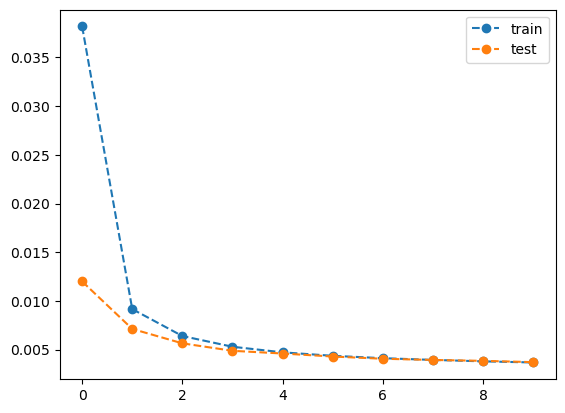

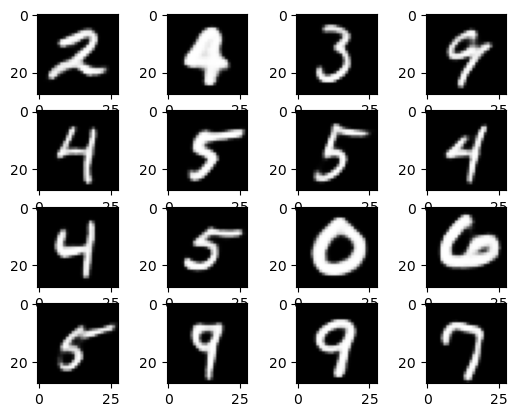

In [ ]:
# Write code for convolutional autoencoder training with MNIST dataset

# Model construction
class ConvAE(nn.Module):
    def __init__(self,dim_c,dim_z):
        super(ConvAE,self).__init__()
        self.dim_z = dim_z

        self.enc_info = [f'conv2d-1,{dim_c},3,1,1;relu;maxpool2d-2,2,0', # [dim_c,14,14]
                         f'conv2d-{dim_c},{2*dim_c},3,1,1;relu;maxpool2d-2,2,0', # [2*dim_c,7,7]
                         f'conv2d-{2*dim_c},{dim_z},7,7,0'] # [dim_z,1,1]

        self.dec_info = [f'convtrans2d-{dim_z},{2*dim_c},7,7,0;relu', # [2*dim_c,7,7]
                         f'convtrans2d-{2*dim_c},{2*dim_c},6,2,2;relu', # [dim_c,14,14]
                         f'convtrans2d-{2*dim_c},1,6,2,2;sigmoid'] # [1,28,28]

        self.encoder = LayerGroup(';'.join(self.enc_info))
        self.decoder = LayerGroup(';'.join(self.dec_info))

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

dim_c = 32
dim_z = 32

AE = ConvAE(dim_c,dim_z).cuda()

print(AE)

# dataset & dataloader construction
training_data = datasets.MNIST(root="./",train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root="./",train=False,download=True,transform=ToTensor())

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

#note; shape of img = [1,28,28], shape of target = [1]

# training code
optimizer = torch.optim.Adam(AE.parameters(), lr=0.0003)

num_epoch = 10
Loss = []

for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')
    AE.train()

    L1 = 0
    N1 = 0
    for x,y in tqdm(train_dataloader):
        x = x.cuda()

        z,x_pred = AE(x)

        loss = torch.mean((x_pred-x)**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L1 += len(x)*loss.detach().cpu().numpy()
        N1 += len(x)

    AE.eval()
    Zs = []
    Xs = []
    Ys = []

    L2 = 0
    N2 = 0
    for x,y in tqdm(test_dataloader):
        x = x.cuda()

        z,x_pred = AE(x)

        loss = torch.mean((x_pred-x)**2)

        L2 += len(x)*loss.detach().cpu().numpy()
        N2 += len(x)

        Zs.append(z.detach().cpu().numpy())
        Xs.append(x_pred.detach().cpu().numpy())
        Ys.append(y.detach().cpu().numpy())

    Loss.append([L1/N1,L2/N2])
    print(Loss[-1])

Loss = np.array(Loss)
Zs = np.vstack(Zs)
Xs = np.vstack(Xs)
Ys = np.hstack(Ys)

plt.figure(dpi=100)
plt.plot(Loss[:,0],'o--',label='train')
plt.plot(Loss[:,1],'o--',label='test')
plt.legend()

plt.figure(dpi=100)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Xs[i].reshape(28,28),cmap='gray')

# Variational Autoencoder with CNN

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(7, 7))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(7, 7))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (5): Sigmoid()
  )
)
============= Epoch: 1 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 310.19it/s]


[0.05310765744447708, 0.025624103367328645]
============= Epoch: 2 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 299.78it/s]


[0.02085891962647438, 0.01781322968304157]
============= Epoch: 3 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 308.71it/s]


[0.01667231216430664, 0.015600974243879318]
============= Epoch: 4 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 314.75it/s]


[0.015121228008468946, 0.014696392008662225]
============= Epoch: 5 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 299.04it/s]


[0.014358880089223385, 0.013998688963055611]
============= Epoch: 6 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 300.57it/s]


[0.013848725820581118, 0.01356042014658451]
============= Epoch: 7 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 312.98it/s]


[0.013481256738801798, 0.01319930518567562]
============= Epoch: 8 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 309.79it/s]


[0.01319857606291771, 0.01325613274127245]
============= Epoch: 9 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 319.64it/s]


[0.013009200235704581, 0.012586802984774112]
============= Epoch: 10 =============


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 301.51it/s]


[0.012814617677529653, 0.012699819131195545]


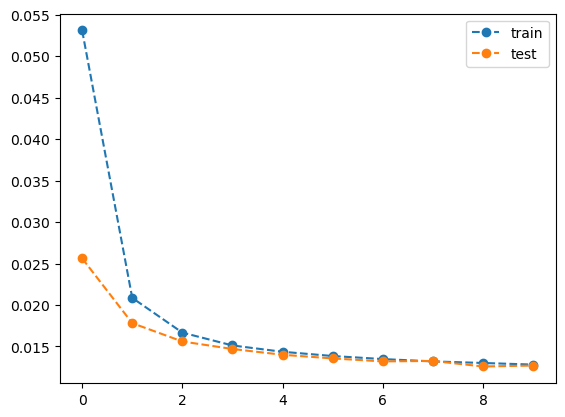

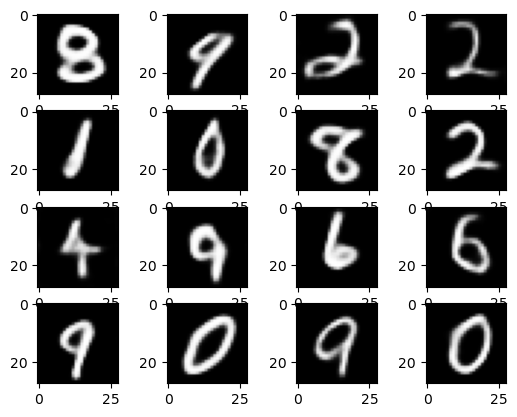

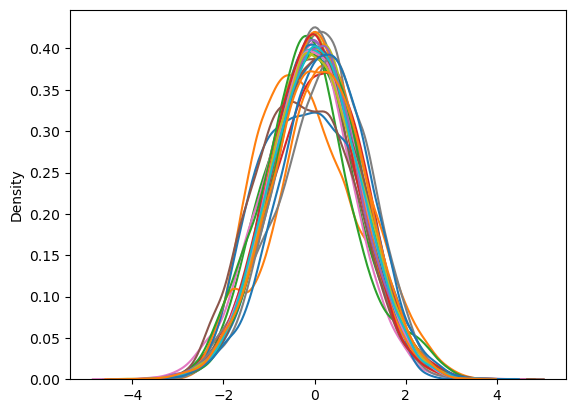

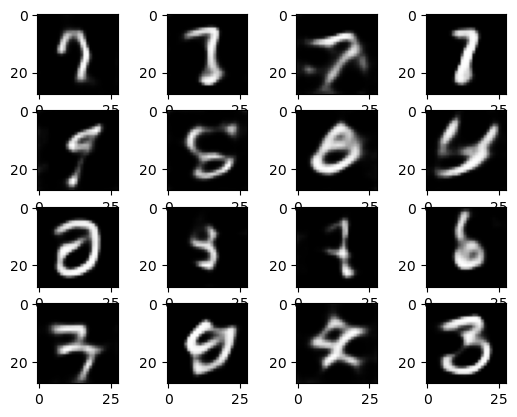

In [ ]:
# Write code for convolutional autoencoder training with MNIST dataset

# Model construction
class ConvVAE(nn.Module):
    def __init__(self,dim_c,dim_z):
        super(ConvVAE,self).__init__()
        self.dim_z = dim_z

        self.enc_info = [f'conv2d-1,{dim_c},3,1,1;relu;maxpool2d-2,2,0', # [dim_c,14,14]
                         f'conv2d-{dim_c},{2*dim_c},3,1,1;relu;maxpool2d-2,2,0', # [2*dim_c,7,7]
                         f'conv2d-{2*dim_c},{2*dim_z},7,7,0'] # [dim_z,1,1]

        self.dec_info = [f'convtrans2d-{dim_z},{2*dim_c},7,7,0;relu', # [2*dim_c,7,7]
                         f'convtrans2d-{2*dim_c},{2*dim_c},6,2,2;relu', # [dim_c,14,14]
                         f'convtrans2d-{2*dim_c},1,6,2,2;sigmoid'] # [1,28,28]

        self.encoder = LayerGroup(';'.join(self.enc_info))
        self.decoder = LayerGroup(';'.join(self.dec_info))

    def forward(self,x):

        nz = self.dim_z
        h = self.encoder(x)

        mu = h[:,:nz]
        logvar = h[:,nz:]

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std

        out = self.decoder(z)
        return z,out,mu,logvar

dim_c = 16
dim_z = 32

AE = ConvVAE(dim_c,dim_z).cuda()

print(AE)

# dataset & dataloader construction
training_data = datasets.MNIST(root="./",train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root="./",train=False,download=True,transform=ToTensor())

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

#note; shape of img = [1,28,28], shape of target = [1]

# training code
optimizer = torch.optim.Adam(AE.parameters(), lr=0.0003)

num_epoch = 10
Loss = []

for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')
    AE.train()

    L1 = 0
    N1 = 0
    for x,y in tqdm(train_dataloader):
        x = x.cuda()

        z,x_pred,mu,logvar = AE(x)

        rec = torch.mean((x_pred-x)**2)
        kld = torch.mean(-0.5*(1 + logvar - mu ** 2 - logvar.exp()))

        loss = rec + 0.015*kld

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L1 += len(x)*rec.detach().cpu().numpy()
        N1 += len(x)

    AE.eval()
    Zs = []
    Xs = []
    Ys = []

    L2 = 0
    N2 = 0
    for x,y in tqdm(test_dataloader):
        x = x.cuda()

        z,x_pred,mu,logvar = AE(x)

        rec = torch.mean((x_pred-x)**2)
        kld = torch.mean(-0.5*(1 + logvar - mu ** 2 - logvar.exp()))

        L2 += len(x)*rec.detach().cpu().numpy()
        N2 += len(x)

        Zs.append(z.detach().cpu().numpy())
        Xs.append(x_pred.detach().cpu().numpy())
        Ys.append(y.detach().cpu().numpy())

    Loss.append([L1/N1,L2/N2])
    print(Loss[-1])

Loss = np.array(Loss)
Zs = np.vstack(Zs).reshape(-1,dim_z)
Xs = np.vstack(Xs)
Ys = np.hstack(Ys)

plt.figure(dpi=100)
plt.plot(Loss[:,0],'o--',label='train')
plt.plot(Loss[:,1],'o--',label='test')
plt.legend()

plt.figure(dpi=100)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Xs[i].reshape(28,28),cmap='gray')

plt.figure(dpi=100)
for i in range(dim_z):
    sns.kdeplot(Zs[:,i])

plt.figure(dpi=100)

z = torch.randn(16,dim_z,1,1).cuda()
x_new = AE.decoder(z).cpu().detach().numpy()

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_new[i].reshape(28,28),cmap='gray')

# GAN (Convolutions)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        self.conv_info = [f'conv2d-1,{conv_dim},4,2,1;lrelu',
                          f'conv2d-{conv_dim},{conv_dim*2},4,2,1;bn2d-{conv_dim*2};lrelu',
                          f'conv2d-{conv_dim*2},{conv_dim*4},4,2,1;bn2d-{conv_dim*4};lrelu',
                          f'conv2d-{conv_dim*4},1,4,2,1']

        self.conv_layer = LayerGroup(';'.join(self.conv_info))

    def forward(self, x):
        B = len(x)

        out = self.conv_layer(x)
        return out.view(-1,1)

class Generator(nn.Module):

    def __init__(self, z_dim, conv_dim):
        super(Generator, self).__init__()

        self.conv_dim = conv_dim

        self.fc_info = f'linear-{z_dim},{conv_dim*4*4*4}'

        self.convtrans_info = [f'convtrans2d-{z_dim},{conv_dim*8},4,1,0;bn2d-{conv_dim*8};relu',
                               f'convtrans2d-{conv_dim*8},{conv_dim*4},4,2,1;bn2d-{conv_dim*4};relu',
                               f'convtrans2d-{conv_dim*4},{conv_dim*2},4,2,1;bn2d-{conv_dim*2};relu',
                               f'convtrans2d-{conv_dim*2},{conv_dim},4,2,1;bn2d-{conv_dim};relu',
                               f'convtrans2d-{conv_dim},1,1,1,2;tanh']

        self.fc_layer = LayerGroup(self.fc_info)
        self.convtrans_layer = LayerGroup(';'.join(self.convtrans_info))

    def forward(self, x):
        B = len(x)
        x = x.view(B,-1,1,1)
        out = self.convtrans_layer(x)
        return out

In [ ]:
# dataset & dataloader construction
training_data = datasets.MNIST(root="./",train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root="./",train=False,download=True,transform=ToTensor())

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

z_dim = 100
conv_dim = 64

D = Discriminator(conv_dim).cuda()
G = Generator(z_dim,conv_dim).cuda()

print(D)
print(G)

beta1 = 0.5
beta2 = 0.999

optim_D = torch.optim.Adam(D.parameters(),lr=0.0002,betas=[beta1,beta2])
optim_G = torch.optim.Adam(G.parameters(),lr=0.0002,betas=[beta1,beta2])

criterion = nn.BCEWithLogitsLoss()

num_epoch = 10
smooth = True

Loss = []
D.train()
G.train()
for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')

    for batch_i,(real_img,_) in enumerate(train_dataloader):

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        batch_size = real_img.shape[0]

        real_img = 2*real_img-1
        real_img = real_img.cuda()

        optim_D.zero_grad()

        D_real = D(real_img)

        if smooth:
            labels = 0.9*torch.ones(batch_size).cuda()
        else:
            labels = torch.ones(batch_size).cuda()

        loss_real = criterion(D_real.view(-1),labels)

        with torch.no_grad():
            z = torch.randn(batch_size,z_dim).cuda()
            fake_img = G(z)

        D_fake = D(fake_img)
        labels = torch.zeros(batch_size).cuda()
        loss_fake = criterion(D_fake.view(-1),labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optim_D.step()

        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

        optim_G.zero_grad()

        z = torch.randn(batch_size,z_dim).cuda()
        fake_img = G(z)

        D_fake = D(fake_img)

        if smooth:
            labels = 0.9*torch.ones(batch_size).cuda()
        else:
            labels = torch.ones(batch_size).cuda()

        loss_G = criterion(D_fake.view(-1),labels)
        loss_G.backward()
        optim_G.step()

        if batch_i % 400 == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epoch, loss_D.item(), loss_G.item()))

Discriminator(
  (conv_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Generator(
  (fc_layer): Sequential(
    (0): Linear(in_features=100, out_features=4096, bias=True)
  )
  (convtrans_layer): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, k

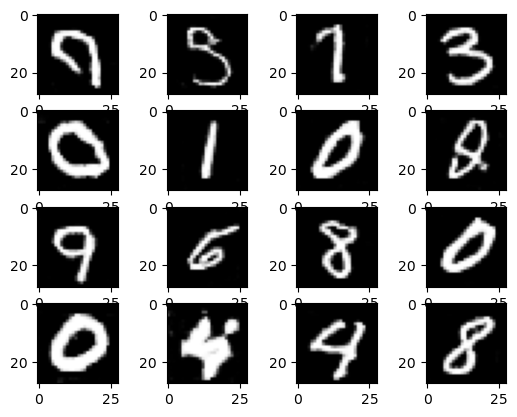

In [ ]:
G.eval()

sample_size=16
z = torch.randn(sample_size,z_dim).cuda()
samples = G(z).cpu().detach().numpy()

for i in range(16):
    plt.subplot(4,4,i+1)

    img = np.transpose(samples[i],(1,2,0))
    img = (img+1)/2

    plt.imshow(img,cmap='gray')